In [1]:
#import packages for logistic analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score

%matplotlib notebook

In [2]:
#set working directory
os.chdir('C:/Users/siree/OneDrive/Desktop/WGU/D208/D208_Files')

In [3]:
#load the dataset
data = pd.read_csv('churn_clean.csv')

In [4]:
#### C1: DATA CLEANING #####

In [5]:
data_cleaned = data.copy()

In [6]:
#identify missing values
print(data_cleaned.isnull().sum())

CaseOrder               0
Customer_id             0
Interaction             0
UID                     0
City                    0
State                   0
County                  0
Zip                     0
Lat                     0
Lng                     0
Population              0
Area                    0
TimeZone                0
Job                     0
Children                0
Age                     0
Income                  0
Marital                 0
Gender                  0
Churn                   0
Outage_sec_perweek      0
Email                   0
Contacts                0
Yearly_equip_failure    0
Techie                  0
Contract                0
Port_modem              0
Tablet                  0
InternetService         0
Phone                   0
Multiple                0
OnlineSecurity          0
OnlineBackup            0
DeviceProtection        0
TechSupport             0
StreamingTV             0
StreamingMovies         0
PaperlessBilling        0
PaymentMetho

In [7]:
#Impute missing values with mean for numerical columns and most frequent for categorical columns
numeric_features = data_cleaned.select_dtypes(include=['int64', 'float64']).columns
categorical_features = data_cleaned.select_dtypes(include=['object']).columns

In [8]:
#Impute numerical features
num_imputer = SimpleImputer(strategy='mean')
data_cleaned[numeric_features] = num_imputer.fit_transform(data_cleaned[numeric_features])

In [9]:
#Impute categorical features
cat_imputer = SimpleImputer(strategy='most_frequent')
data_cleaned[categorical_features] = cat_imputer.fit_transform(data_cleaned[categorical_features])

In [10]:
#Detect outliers using Z-score
def detect_outliers(df, features):
    outlier_indices = []
    for feature in features:
#Calculate the Z-score
        z_scores = np.abs((df[feature] - df[feature].mean()) / df[feature].std())
#find outliers
        outliers = list(np.where(z_scores > 3)[0])
        outlier_indices.extend(outliers)
    return list(set(outlier_indices))

In [11]:
#List of numerical features to check for outliers
outlier_indices = detect_outliers(data_cleaned, numeric_features)

In [12]:
#Remove outliers
outliers = data_cleaned.index.isin(outlier_indices)
data_cleaned = data_cleaned[~outliers].copy()

In [13]:
#Remove irrelevant columns
irrelevant_columns = ['CaseOrder', 'Customer_id', 'Interaction', 'UID', 'Email', 'City', 'State', 'County', 'Lat', 'Lng', 'Zip', 'Job', 'TimeZone', 'Item1', 'Item2', 'Item3', 'Item4', 'Item5', 'Item6', 'Item7', 'Item8']
columns_to_drop = [col for col in irrelevant_columns if col in data_cleaned.columns]
data_cleaned.drop(columns=columns_to_drop, inplace = True)

In [14]:
#Convert categorical variables to numerical using one-hot encoding
data_cleaned = pd.get_dummies(data_cleaned, drop_first = True)

In [15]:
#VIF 
X = data_cleaned.drop(columns=['Churn_Yes'])
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                                  feature           VIF
0                              Population      1.528416
1                                Children     12.159335
2                                     Age     47.352971
3                                  Income      3.335034
4                      Outage_sec_perweek     12.630640
5                                Contacts      2.098301
6                    Yearly_equip_failure      1.418888
7                                  Tenure  17123.783762
8                           MonthlyCharge   1308.511844
9                       Bandwidth_GB_Year  21864.662861
10                          Area_Suburban      2.009040
11                             Area_Urban      2.002355
12                        Marital_Married      1.914755
13                  Marital_Never Married      1.944974
14                      Marital_Separated      1.967070
15                        Marital_Widowed      1.984164
16                            Gender_Male      5

In [16]:
##### C2: SUMMARY STATISTIC ##############

In [17]:
#Summary of target variable (Churn)
churn_distribution = data_cleaned['Churn_Yes'].value_counts(normalize=True) * 100
print("Churn Distribution:\n", churn_distribution)

Churn Distribution:
 0    73.340782
1    26.659218
Name: Churn_Yes, dtype: float64


In [18]:
quantitative_vars = ['Population', 'Children', 'Age', 'Income', 'Outage_sec_perweek',
                     'Contacts', 'Yearly_equip_failure', 'Tenure', 'MonthlyCharge', 'Bandwidth_GB_Year']
summary_stats = data_cleaned[quantitative_vars].describe()
print("\nSummary Statistics for Quantitative Variables:\n", summary_stats)


Summary Statistics for Quantitative Variables:
          Population     Children          Age         Income  \
count   8950.000000  8950.000000  8950.000000    8950.000000   
mean    8508.409274     1.941453    53.161341   38329.400298   
std    11759.988903     1.890668    20.634274   25123.528844   
min        0.000000     0.000000    18.000000     348.670000   
25%      727.250000     0.000000    35.000000   19041.117500   
50%     2750.000000     1.000000    53.000000   32778.475000   
75%    11838.750000     3.000000    71.000000   52280.437500   
max    52967.000000     8.000000    89.000000  124025.100000   

       Outage_sec_perweek     Contacts  Yearly_equip_failure       Tenure  \
count         8950.000000  8950.000000           8950.000000  8950.000000   
mean            10.009065     0.941676              0.374749    34.423473   
std              2.926500     0.900798              0.582945    26.445276   
min              1.144796     0.000000              0.000000     1

In [19]:
categorical_vars = ['Area_Suburban', 'Area_Urban', 'Marital_Married', 'Marital_Never Married',
                    'Marital_Separated', 'Marital_Widowed', 'Gender_Male', 'Gender_Nonbinary',
                    'Techie_Yes', 'Contract_One year', 'Contract_Two Year', 'Port_modem_Yes',
                    'Tablet_Yes', 'InternetService_Fiber Optic', 'InternetService_None', 'Phone_Yes',
                    'Multiple_Yes', 'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes',
                    'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes', 'PaperlessBilling_Yes',
                    'PaymentMethod_Credit Card (automatic)', 'PaymentMethod_Electronic Check', 'PaymentMethod_Mailed Check']
categorical_summary = data_cleaned[categorical_vars].apply(lambda x: x.value_counts(normalize=True) * 100)
print("\nSummary for Categorical Variables:\n", categorical_summary)


Summary for Categorical Variables:
    Area_Suburban  Area_Urban  Marital_Married  Marital_Never Married  \
0      66.547486   66.793296         81.01676              80.413408   
1      33.452514   33.206704         18.98324              19.586592   

   Marital_Separated  Marital_Widowed  Gender_Male  Gender_Nonbinary  \
0          79.843575        79.575419    52.513966         97.687151   
1          20.156425        20.424581    47.486034          2.312849   

   Techie_Yes  Contract_One year  ...  OnlineSecurity_Yes  OnlineBackup_Yes  \
0    83.26257          78.893855  ...            64.24581         54.893855   
1    16.73743          21.106145  ...            35.75419         45.106145   

   DeviceProtection_Yes  TechSupport_Yes  StreamingTV_Yes  \
0              56.24581        62.603352        50.681564   
1              43.75419        37.396648        49.318436   

   StreamingMovies_Yes  PaperlessBilling_Yes  \
0            50.916201             41.240223   
1          

In [20]:
######## C3: UNIVARIATE AND BIVARIATE ########

<IPython.core.display.Javascript object>


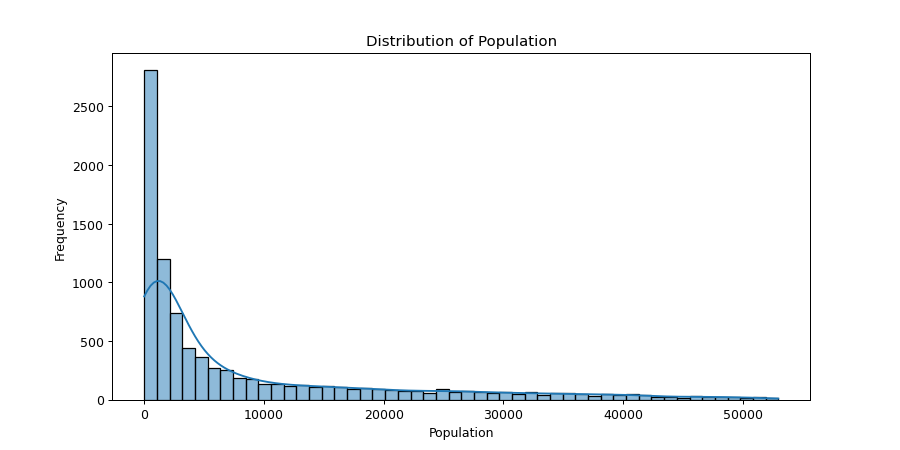

<IPython.core.display.Javascript object>


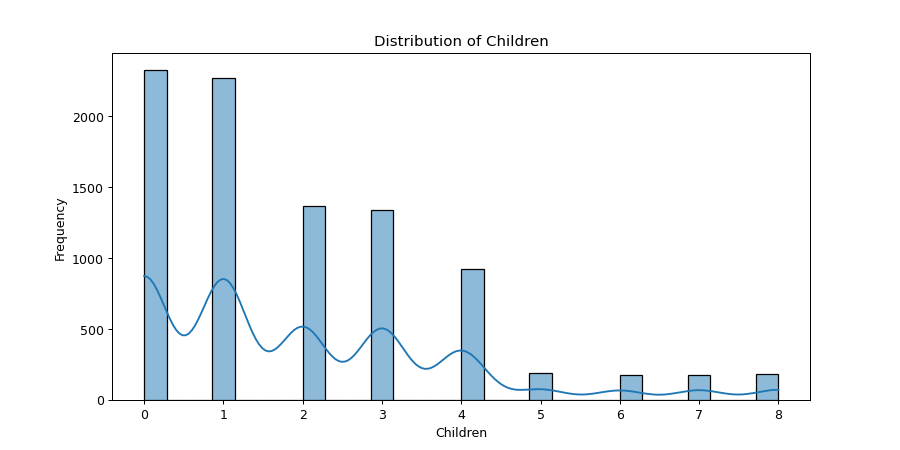

<IPython.core.display.Javascript object>


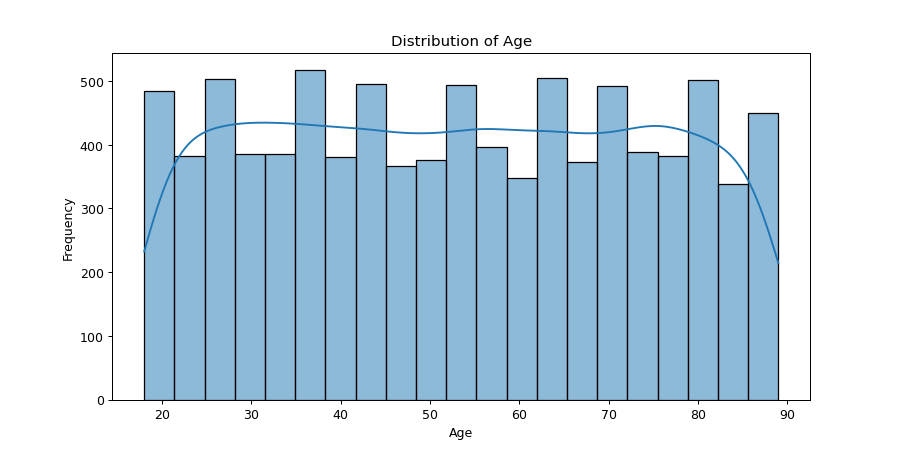

<IPython.core.display.Javascript object>


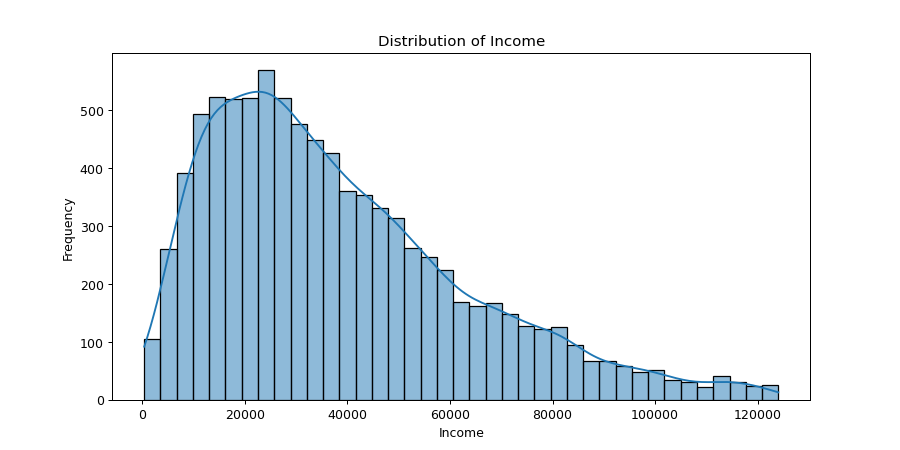

<IPython.core.display.Javascript object>


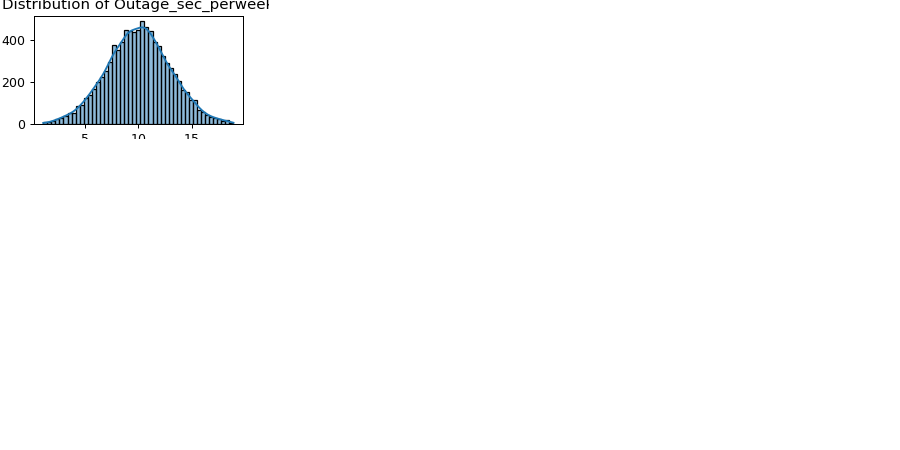

<IPython.core.display.Javascript object>


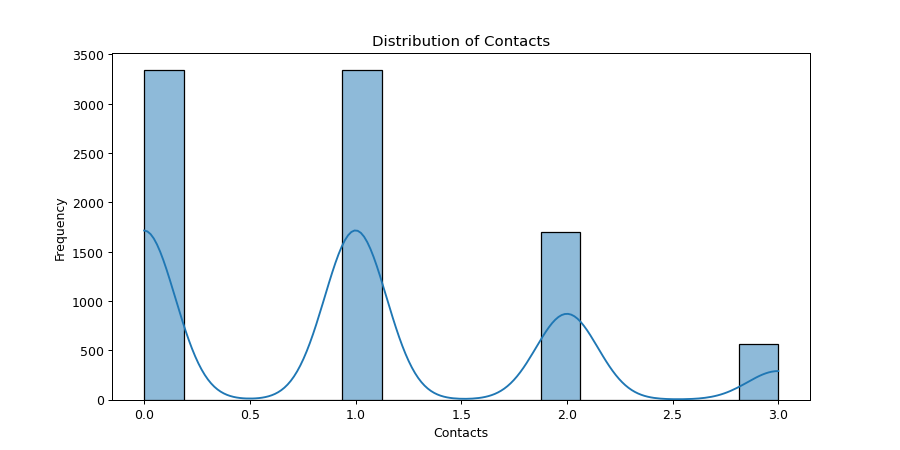

<IPython.core.display.Javascript object>


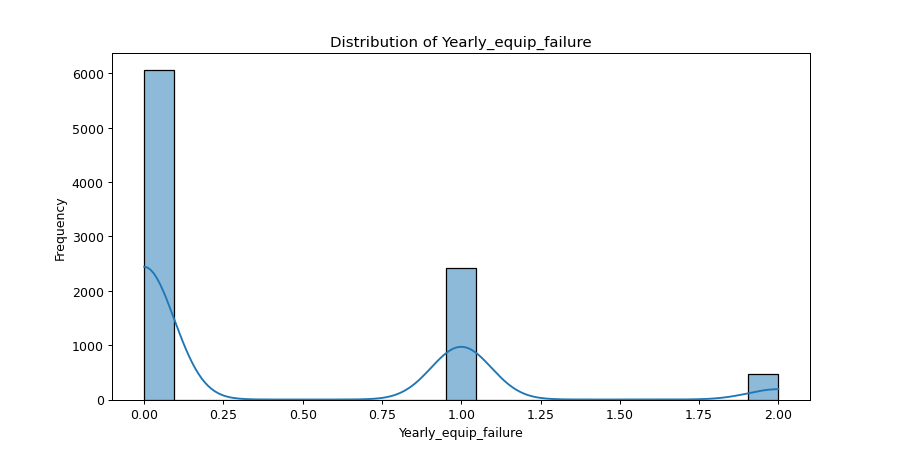

<IPython.core.display.Javascript object>


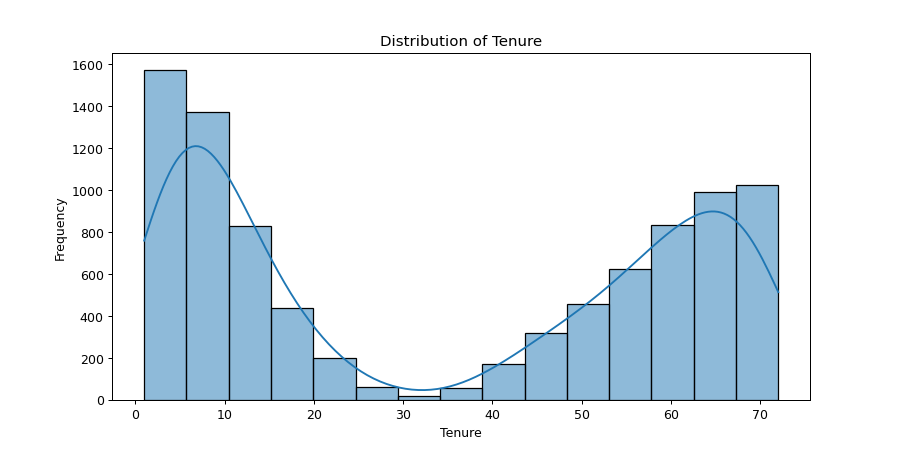

<IPython.core.display.Javascript object>


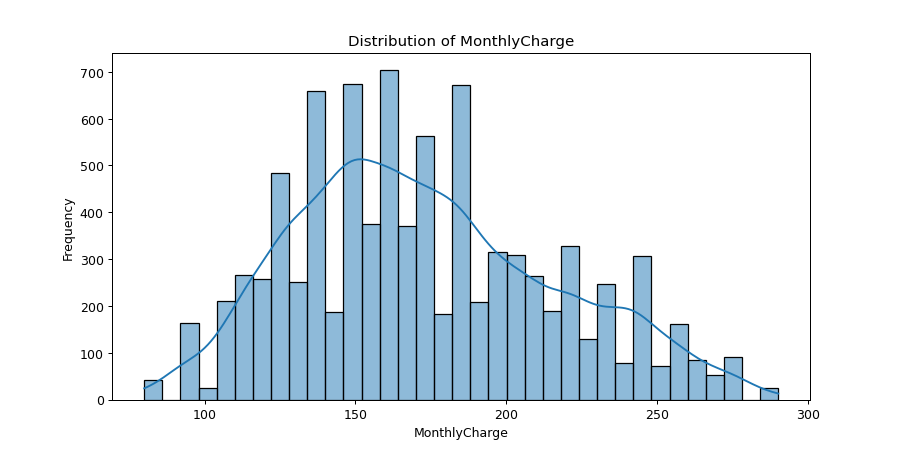

<IPython.core.display.Javascript object>


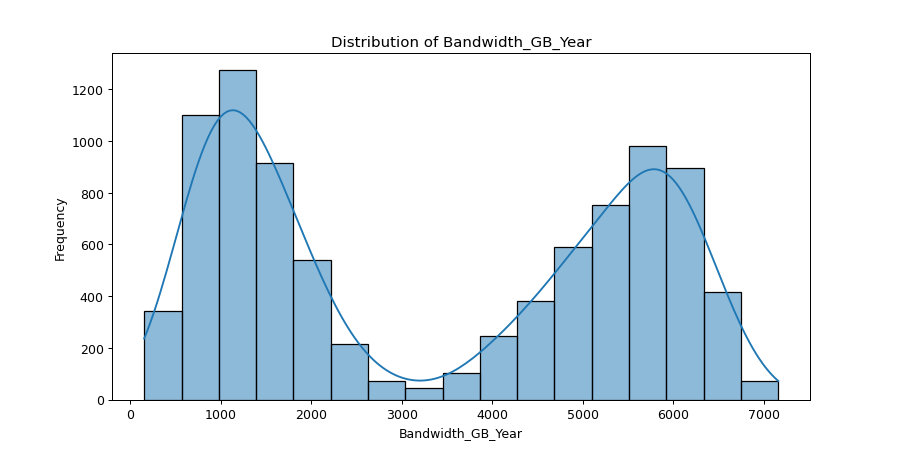

In [21]:
# Univariate visualizations for quantitative variables
quantitative_columns = ['Population', 'Children', 'Age', 'Income', 'Outage_sec_perweek', 
                        'Contacts', 'Yearly_equip_failure', 'Tenure', 'MonthlyCharge', 'Bandwidth_GB_Year']

for col in quantitative_columns:
    plt.figure(figsize=(10, 5))
    sns.histplot(data_cleaned[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

<IPython.core.display.Javascript object>


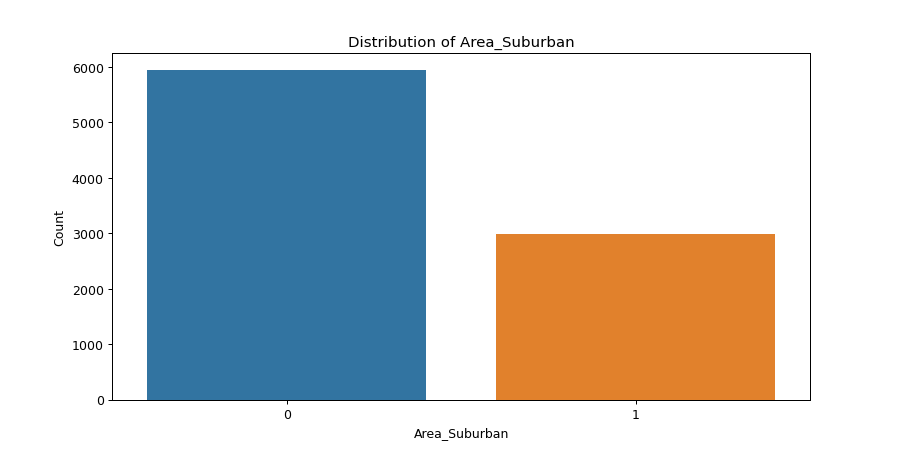

<IPython.core.display.Javascript object>


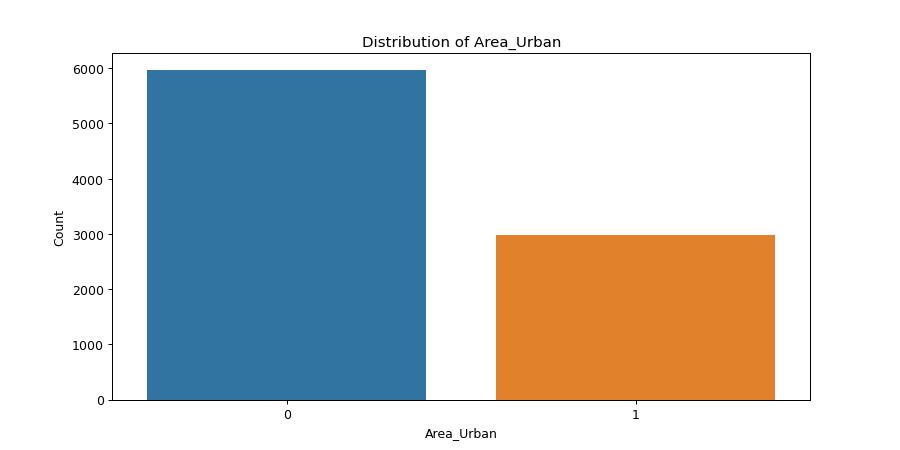

<IPython.core.display.Javascript object>


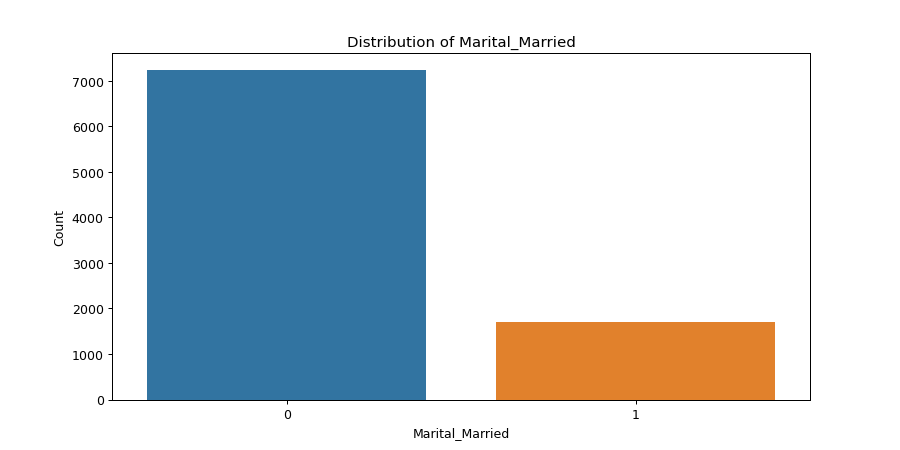

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


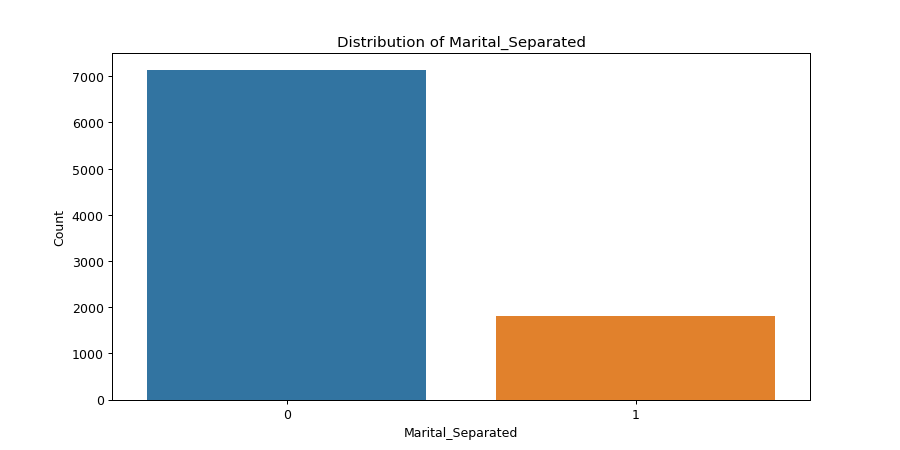

<IPython.core.display.Javascript object>


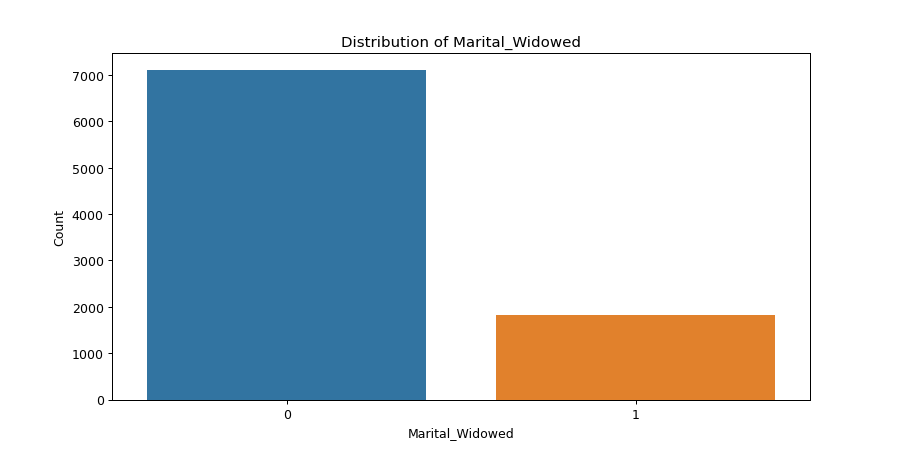

<IPython.core.display.Javascript object>


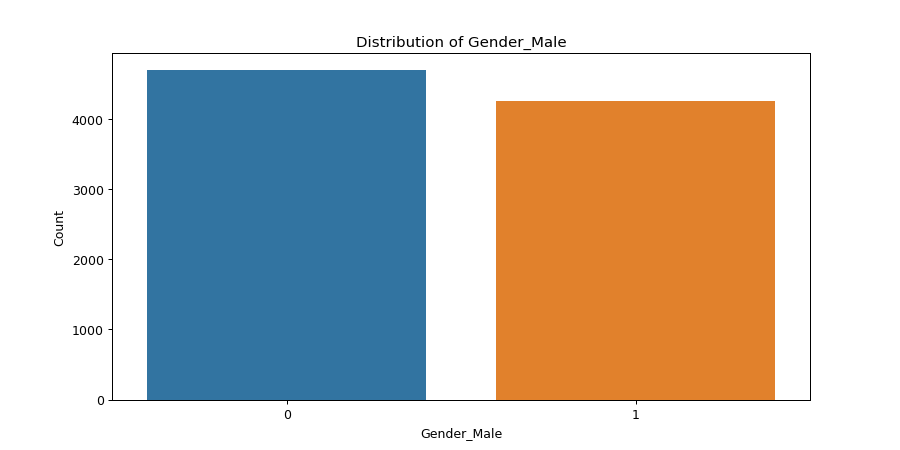

<IPython.core.display.Javascript object>


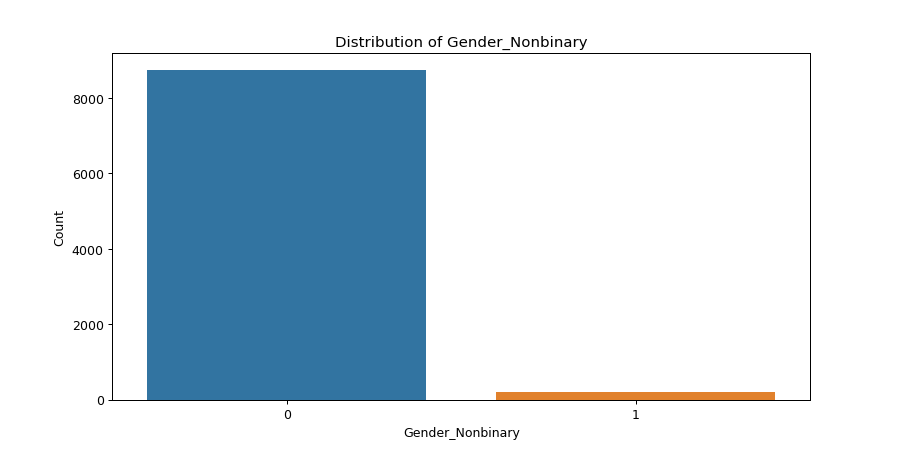

<IPython.core.display.Javascript object>


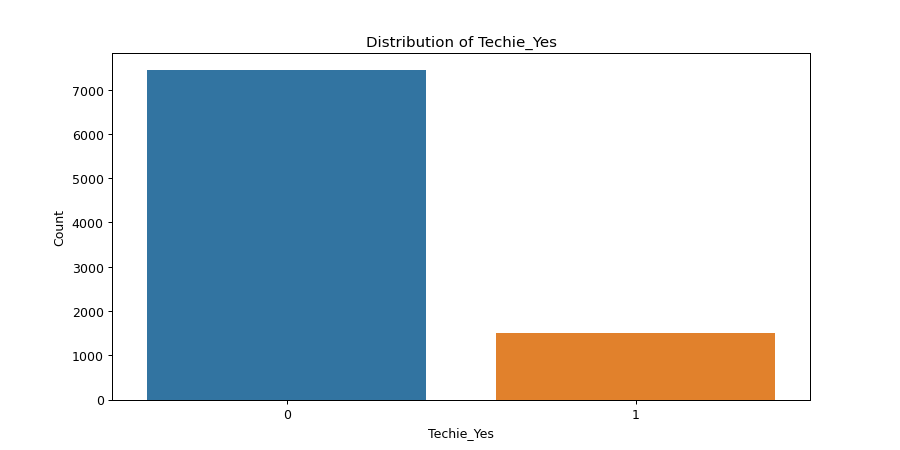

<IPython.core.display.Javascript object>


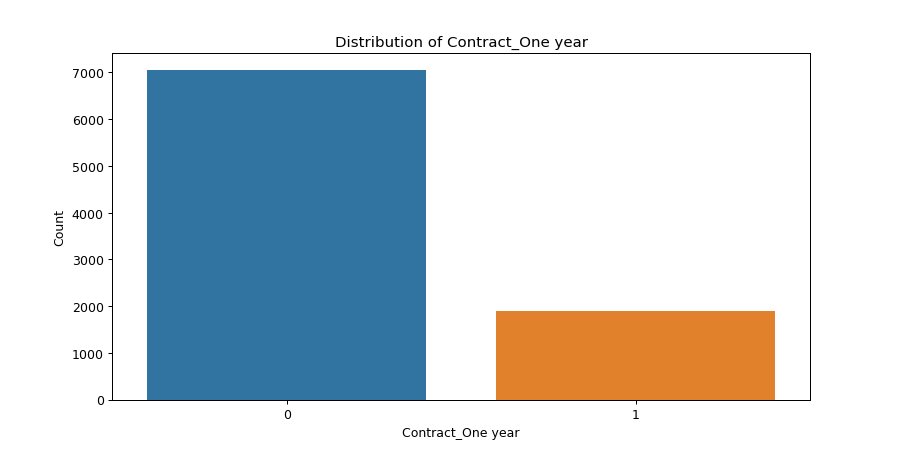

C:\Users\siree\AppData\Local\Temp\ipykernel_16916\4241780281.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))


<IPython.core.display.Javascript object>


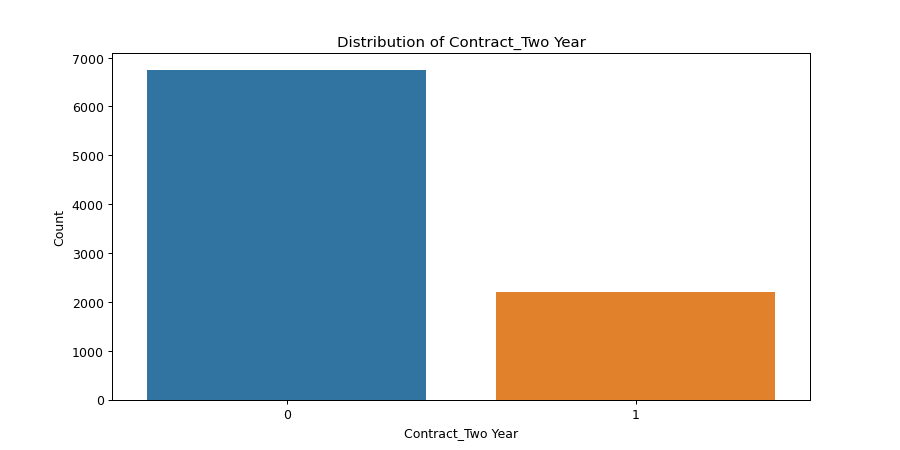

<IPython.core.display.Javascript object>


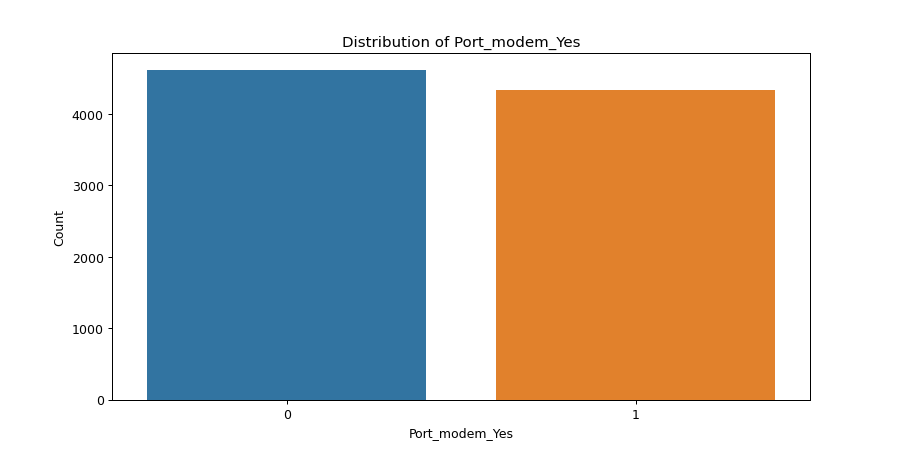

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
# Univariate visualizations for categorical variables
categorical_columns = ['Area_Suburban', 'Area_Urban', 'Marital_Married', 'Marital_Never Married', 
                       'Marital_Separated', 'Marital_Widowed', 'Gender_Male', 'Gender_Nonbinary', 
                       'Techie_Yes', 'Contract_One year', 'Contract_Two Year', 'Port_modem_Yes', 
                       'Tablet_Yes', 'InternetService_Fiber Optic', 'InternetService_None', 'Phone_Yes', 
                       'Multiple_Yes', 'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes', 
                       'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes', 'PaperlessBilling_Yes', 
                       'PaymentMethod_Credit Card (automatic)', 'PaymentMethod_Electronic Check', 
                       'PaymentMethod_Mailed Check']

for col in categorical_columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=col, data=data_cleaned)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

<IPython.core.display.Javascript object>


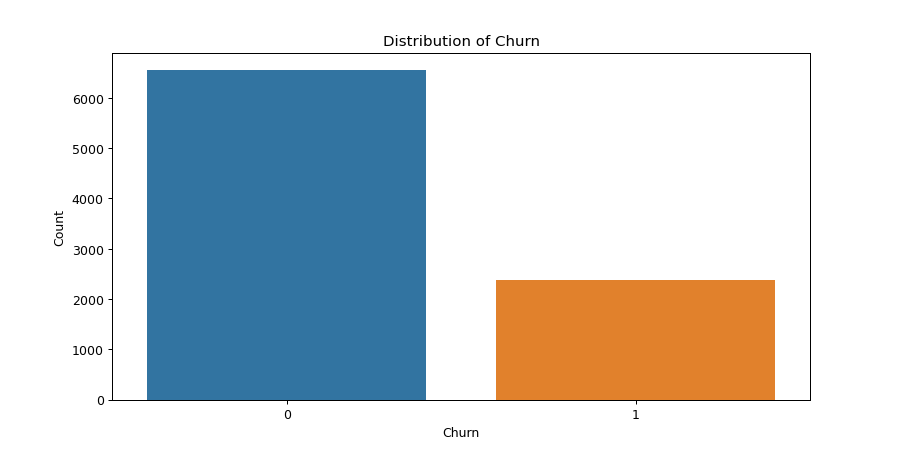

In [23]:
# Univariate visualization for the dependent variable
plt.figure(figsize=(10, 5))
sns.countplot(x='Churn_Yes', data=data_cleaned)
plt.title('Distribution of Churn')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

<IPython.core.display.Javascript object>


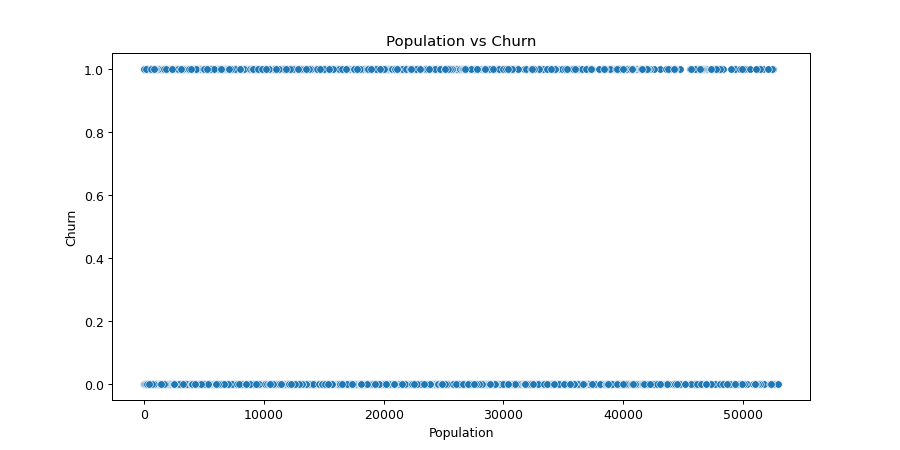

<IPython.core.display.Javascript object>


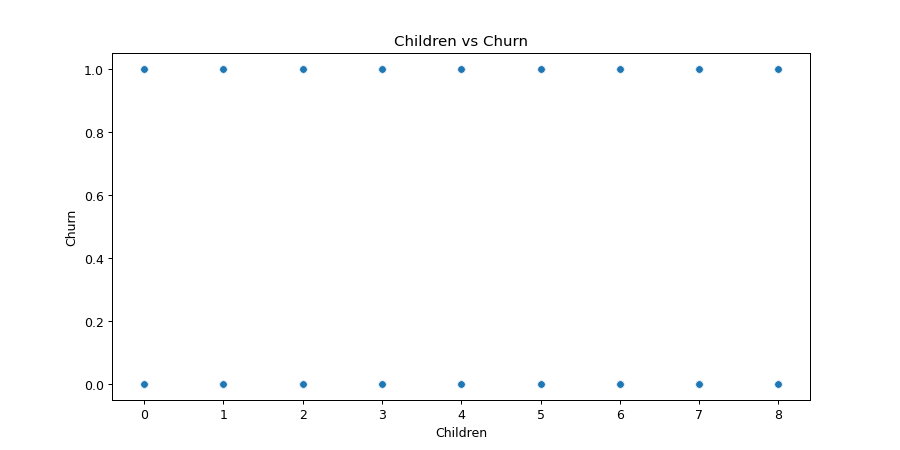

<IPython.core.display.Javascript object>


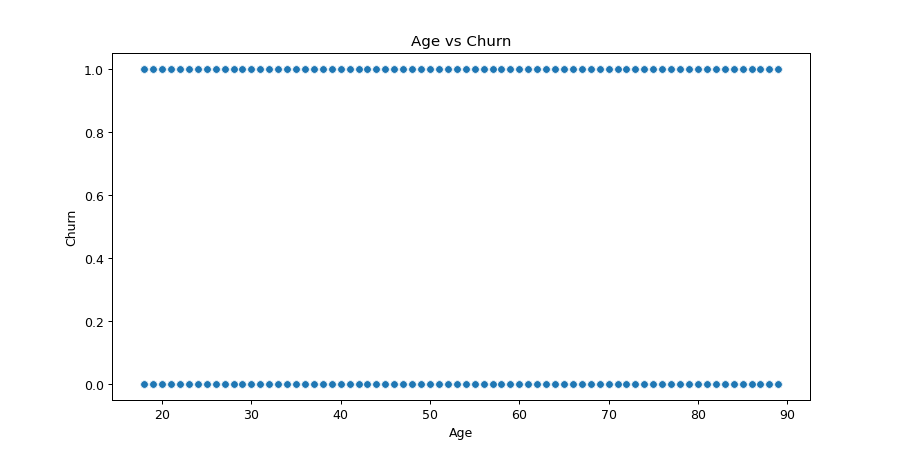

<IPython.core.display.Javascript object>


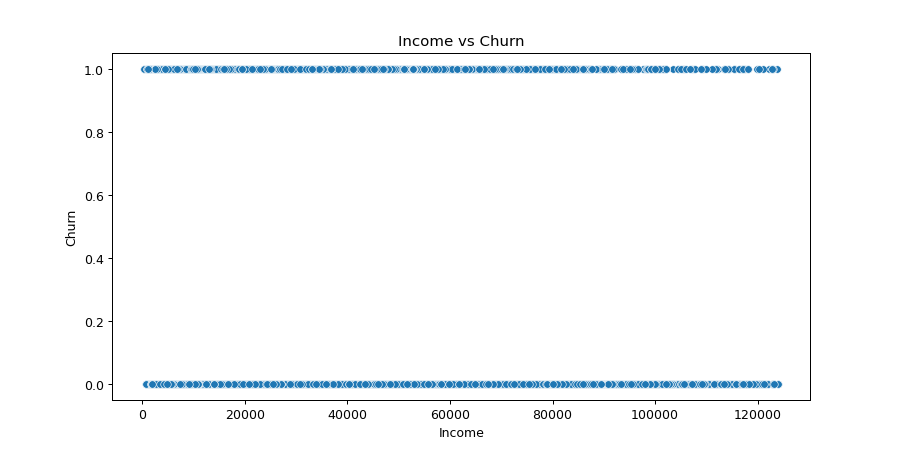

<IPython.core.display.Javascript object>


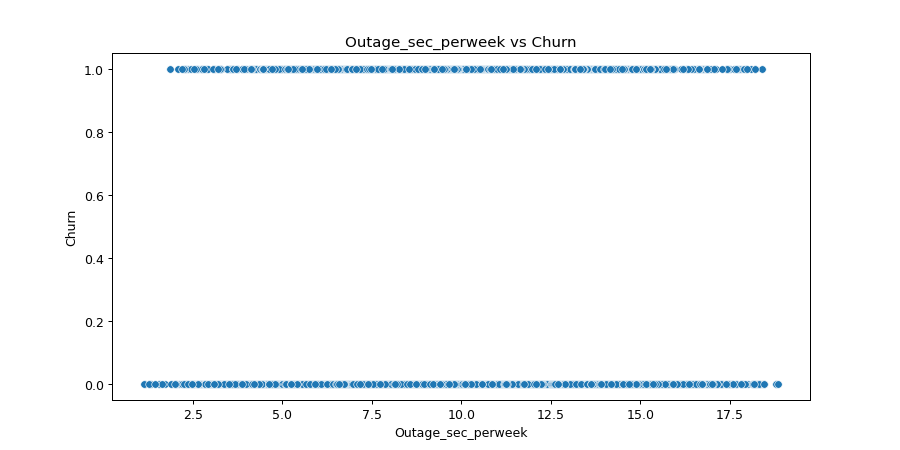

<IPython.core.display.Javascript object>


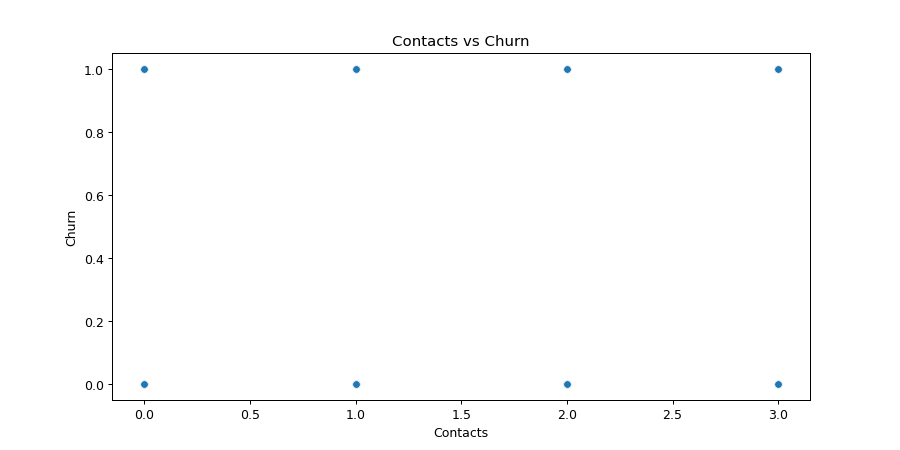

<IPython.core.display.Javascript object>


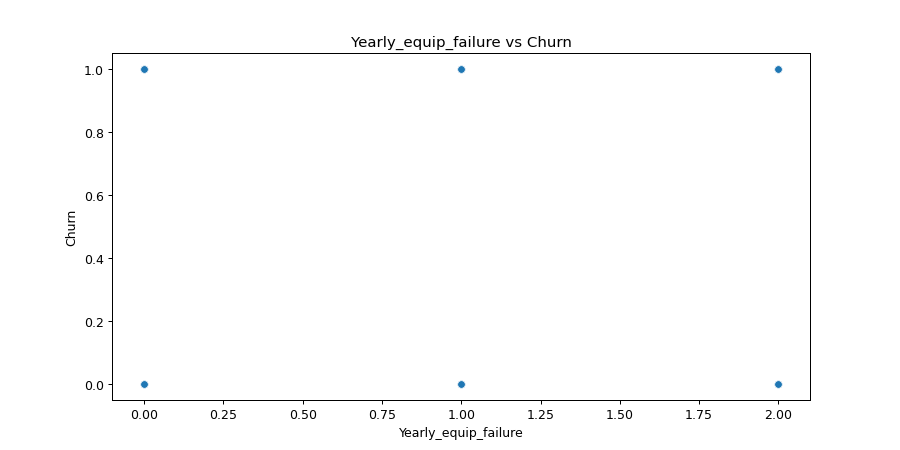

<IPython.core.display.Javascript object>


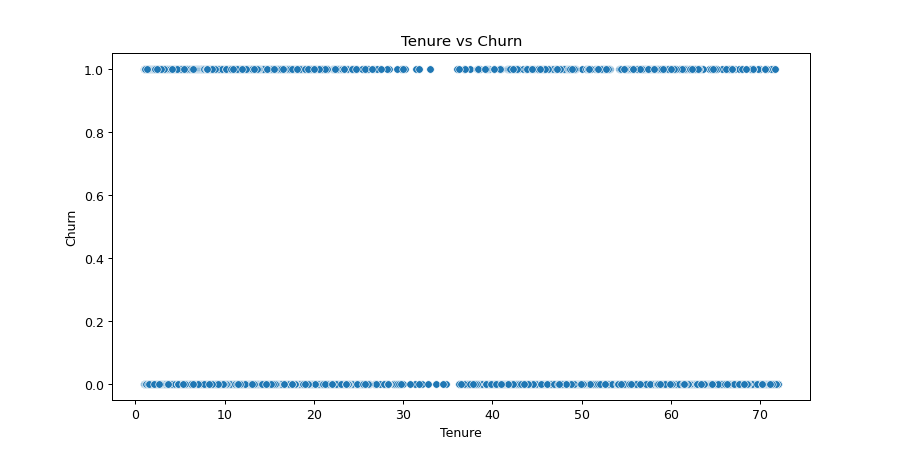

<IPython.core.display.Javascript object>


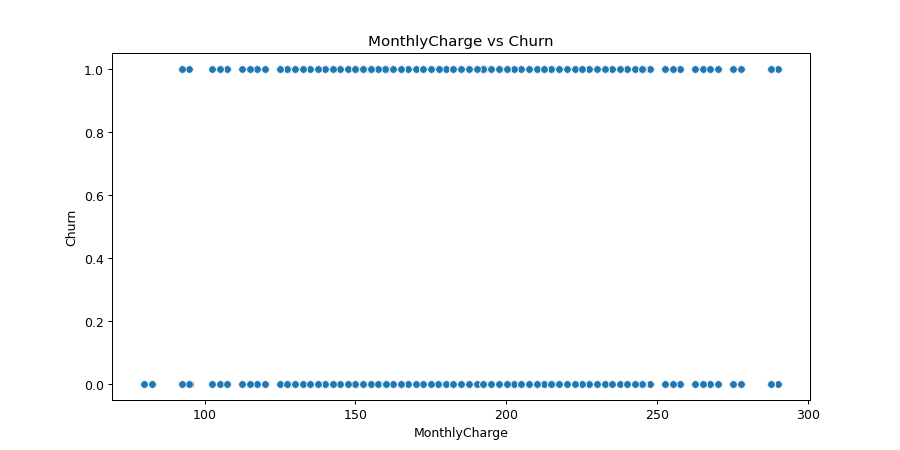

<IPython.core.display.Javascript object>

In [24]:
# Bivariate visualizations for quantitative variables vs. Churn
for col in quantitative_columns:
    plt.figure(figsize=(10, 5))
    sns.scatterplot(x=data_cleaned[col], y=data_cleaned['Churn_Yes'])
    plt.title(f'{col} vs Churn')
    plt.xlabel(col)
    plt.ylabel('Churn')
    plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


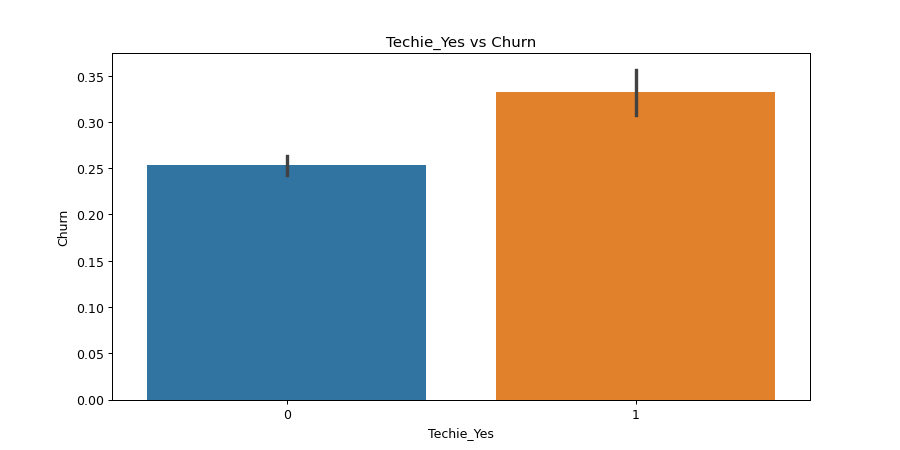

<IPython.core.display.Javascript object>


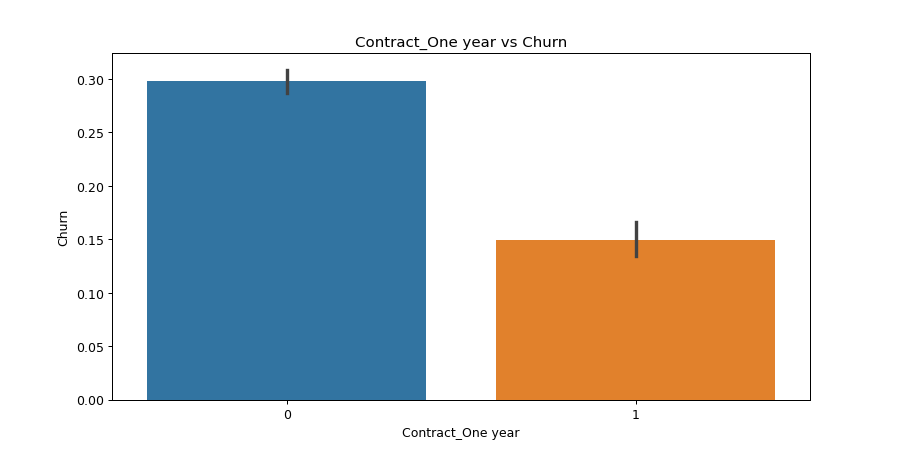

<IPython.core.display.Javascript object>


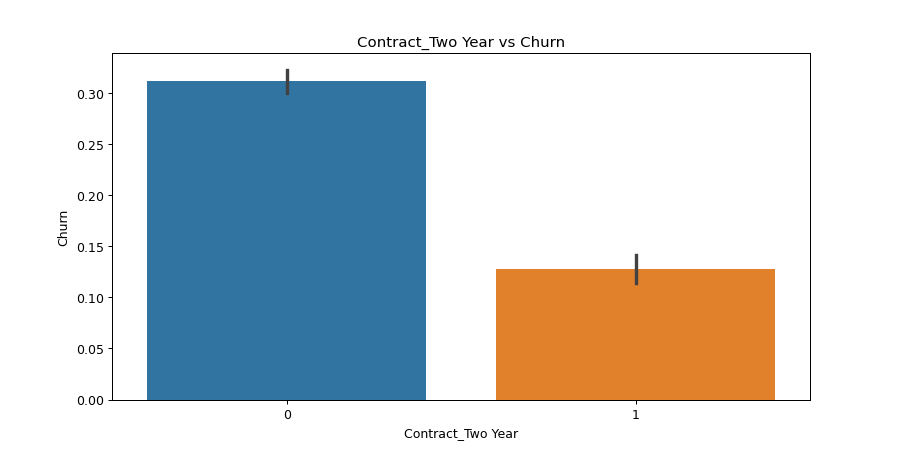

<IPython.core.display.Javascript object>


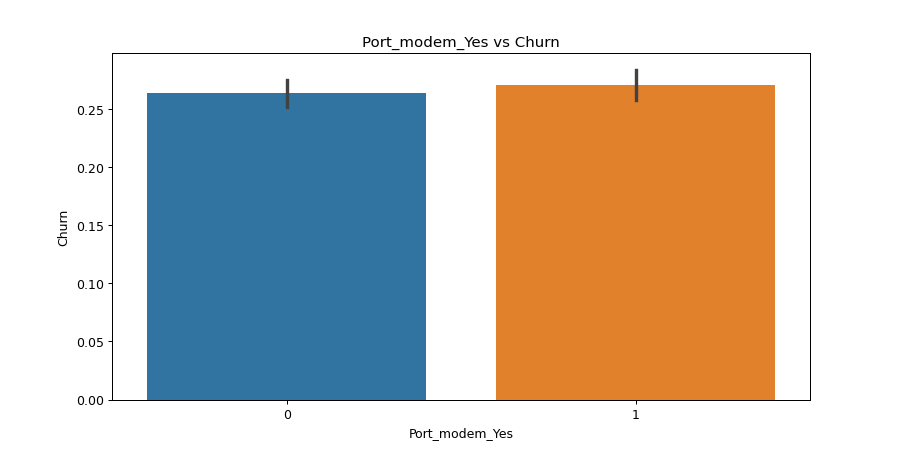

<IPython.core.display.Javascript object>


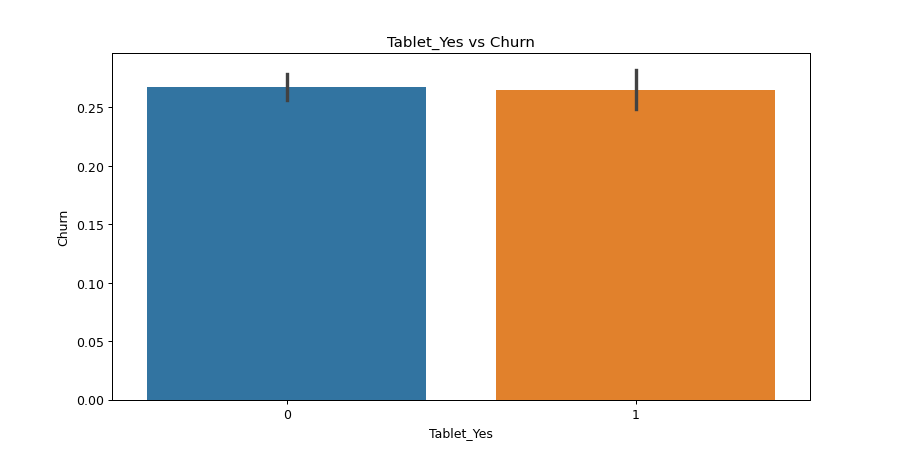

<IPython.core.display.Javascript object>


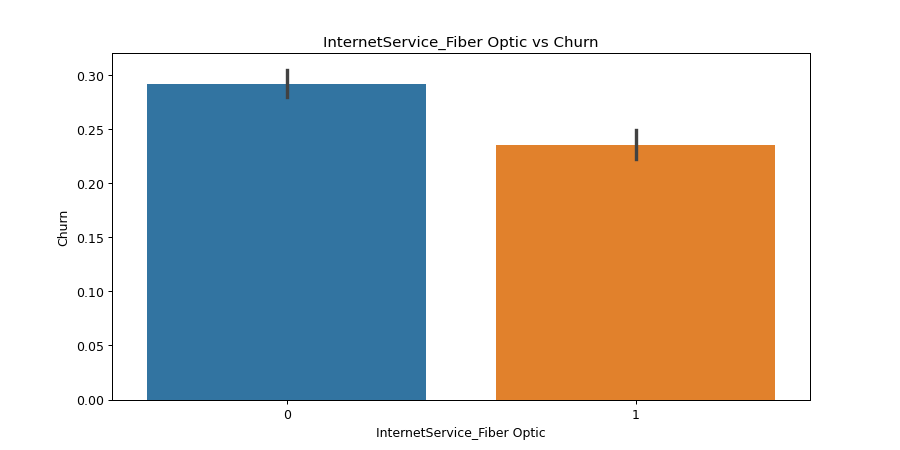

<IPython.core.display.Javascript object>


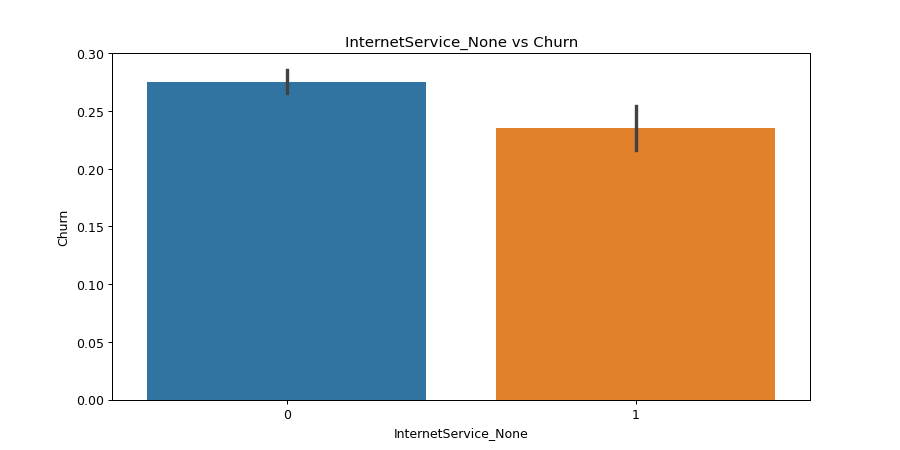

<IPython.core.display.Javascript object>


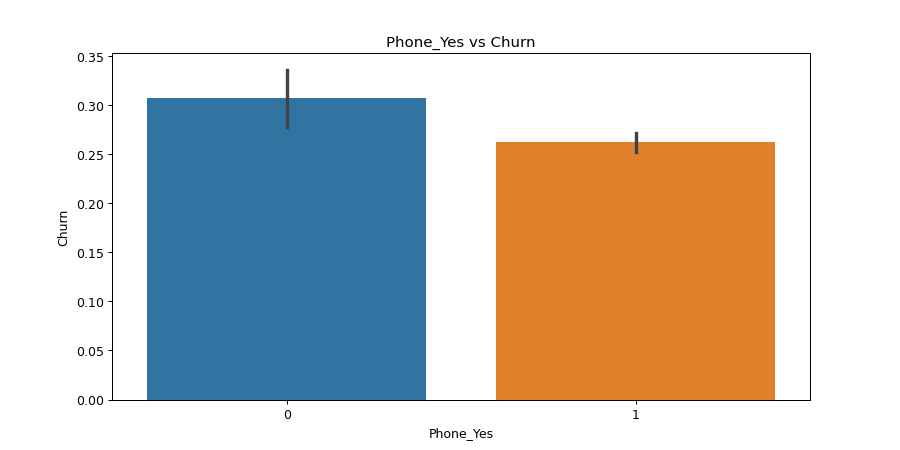

<IPython.core.display.Javascript object>


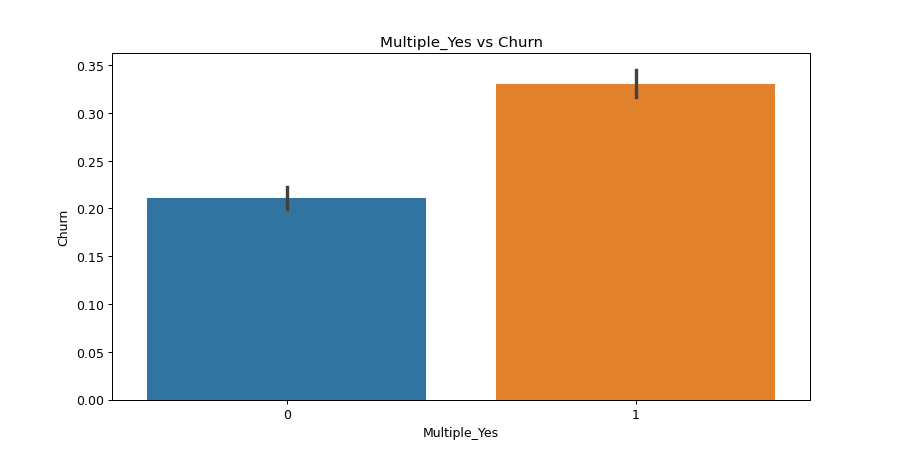

<IPython.core.display.Javascript object>


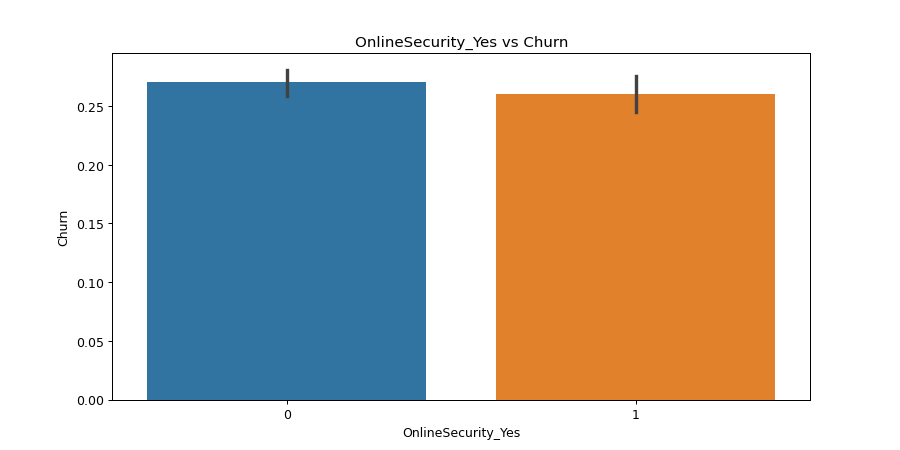

<IPython.core.display.Javascript object>


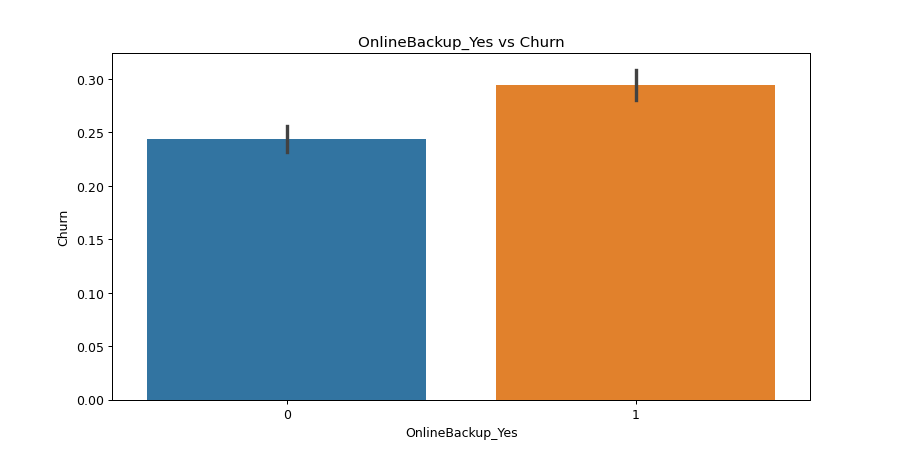

<IPython.core.display.Javascript object>


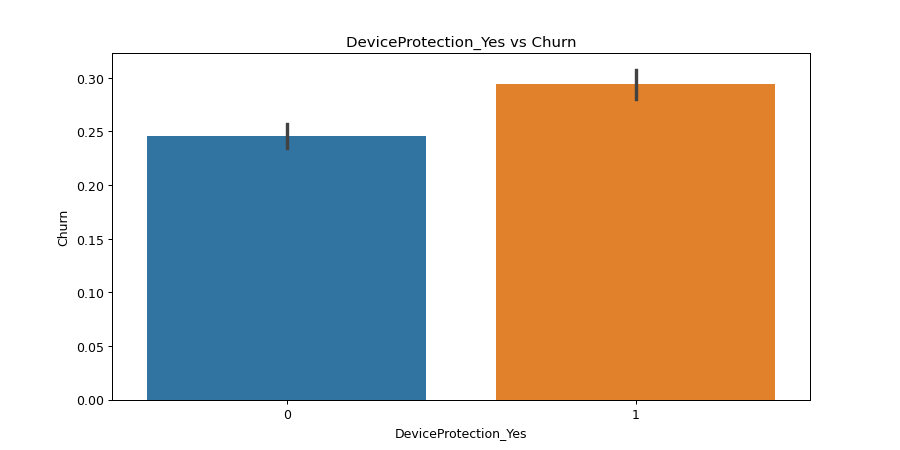

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
# Bivariate visualizations for categorical variables vs. Churn
for col in categorical_columns:
    plt.figure(figsize=(10, 5))
    sns.barplot(x=col, y='Churn_Yes', data=data_cleaned)
    plt.title(f'{col} vs Churn')
    plt.xlabel(col)
    plt.ylabel('Churn')
    plt.show()

In [26]:
#### C4: DATA TRANSFORMATION #####

In [27]:
#create dummies
data = pd.get_dummies(data_cleaned, drop_first=True)

In [28]:
#export as a CSV
data.to_csv('C:/Users/siree/OneDrive/Desktop/WGU/D208/TASK_2/SIREEN_SHABAN_D208_TASK2.csv')

In [29]:
#### D1: INITIAL MODEL #####

In [100]:
#Separate features (X) and target variable (y)
X = data.drop(columns=['Churn_Yes'])
y = data['Churn_Yes']

In [101]:
categorical_columns = ['Area_Suburban', 'Area_Urban', 'Marital_Married', 'Marital_Never Married', 
                       'Marital_Separated', 'Marital_Widowed', 'Gender_Male', 'Gender_Nonbinary', 
                       'Techie_Yes', 'Contract_One year', 'Contract_Two Year', 'Port_modem_Yes', 
                       'Tablet_Yes', 'InternetService_Fiber Optic', 'InternetService_None', 'Phone_Yes', 
                       'Multiple_Yes', 'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes', 
                       'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes', 'PaperlessBilling_Yes', 
                       'PaymentMethod_Credit Card (automatic)', 'PaymentMethod_Electronic Check', 
                       'PaymentMethod_Mailed Check']

In [102]:
continuous_columns = ['Population', 'Children', 'Age', 'Income', 'Outage_sec_perweek', 
                      'Contacts', 'Yearly_equip_failure', 'Tenure', 'MonthlyCharge', 'Bandwidth_GB_Year']

In [103]:
#Ensure categorical variables are in the correct format
X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

In [104]:
#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [105]:
#Reset the index of y_train and X_train to ensure alignment
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

In [106]:
#Add a constant to the model (intercept)
X_train_const = sm.add_constant(X_train)

In [107]:
#Fit the initial logistic regression model using statsmodels
initial_model = sm.Logit(y_train, X_train_const)
initial_result = initial_model.fit()

Optimization terminated successfully.
         Current function value: inf
         Iterations 9


C:\Users\siree\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\siree\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


In [108]:
#Print the summary
print("Initial Logistic Regression Model Summary:")
print(initial_result.summary())

Initial Logistic Regression Model Summary:
                           Logit Regression Results                           
Dep. Variable:              Churn_Yes   No. Observations:                 6265
Model:                          Logit   Df Residuals:                     6227
Method:                           MLE   Df Model:                           37
Date:                Mon, 22 Jul 2024   Pseudo R-squ.:                     inf
Time:                        16:35:42   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                      -5.1163      1.864     -2.745      0.006      -8.769      -1.463
P

C:\Users\siree\anaconda3\Lib\site-packages\statsmodels\base\model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\siree\anaconda3\Lib\site-packages\statsmodels\base\model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


In [132]:
initial_accuracy = accuracy_score(y_test, initial_result.predict(sm.add_constant(X_test)) > 0.5)
print(f"Accuracy of the initial model: {initial_accuracy:.2f}")

Accuracy of the initial model: 0.90


In [ ]:
##### D3: REDUCED LOGISTIC REGRESSION MODEL#############

In [109]:
#Separate the target variable and features
X = data.drop(columns=['Churn_Yes'])
y = data['Churn_Yes']

In [110]:
categorical_columns = ['Area_Suburban', 'Area_Urban', 'Marital_Married', 'Marital_Never Married', 
                       'Marital_Separated', 'Marital_Widowed', 'Gender_Male', 'Gender_Nonbinary', 
                       'Techie_Yes', 'Contract_One year', 'Contract_Two Year', 'Port_modem_Yes', 
                       'Tablet_Yes', 'InternetService_Fiber Optic', 'InternetService_None', 'Phone_Yes', 
                       'Multiple_Yes', 'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes', 
                       'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes', 'PaperlessBilling_Yes', 
                       'PaymentMethod_Credit Card (automatic)', 'PaymentMethod_Electronic Check', 
                       'PaymentMethod_Mailed Check']

In [111]:
continuous_columns = ['Population', 'Children', 'Age', 'Income', 'Outage_sec_perweek', 
                      'Contacts', 'Yearly_equip_failure', 'Tenure', 'MonthlyCharge', 'Bandwidth_GB_Year']

In [112]:
#Ensure categorical variables are in the correct format
X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

In [113]:
#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [114]:
#Reset the index of y_train and X_train to ensure alignment
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

In [115]:
#Add a constant to the model for VIF calculation
X_train_const_vif = sm.add_constant(X_train)

In [116]:
#Calculate VIF for each feature
def calculate_vif(X):
    vif = pd.DataFrame()
    vif["Feature"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

In [117]:
#Calculate VIF and print
vif_df = calculate_vif(X_train_const_vif)
print("Initial VIF values:\n", vif_df)

Initial VIF values:
                                     Feature           VIF
0                                     const   1436.613410
1                                Population      1.005575
2                                  Children     44.497350
3                                       Age     60.290995
4                                    Income      1.005452
5                        Outage_sec_perweek      1.005627
6                                  Contacts      1.004434
7                      Yearly_equip_failure      1.005279
8                                    Tenure  60749.752367
9                             MonthlyCharge    222.416122
10                        Bandwidth_GB_Year  61877.024781
11                          Area_Suburban_1      1.326877
12                             Area_Urban_1      1.326354
13                        Marital_Married_1      1.555367
14                  Marital_Never Married_1      1.577341
15                      Marital_Separated_1      1.

In [118]:
#remove high VIF
high_vif_features = vif_df[vif_df["VIF"] > 10]["Feature"].tolist()
high_vif_features.remove('const') 

In [119]:
#Create a list of selected features after removing high VIF features
selected_features_vif = [feature for feature in X_train.columns if feature not in high_vif_features]

In [120]:
#Transform the dataset to include only the selected features
X_train_reduced_vif = X_train[selected_features_vif]
X_test_reduced_vif = X_test[selected_features_vif]

In [121]:
#Add a constant to the reduced set for VIF recalculation
X_train_reduced_vif_const = sm.add_constant(X_train_reduced_vif)

In [122]:
#Recalculate VIF to ensure multicollinearity is reduced
vif_df_reduced = calculate_vif(X_train_reduced_vif_const)
print("Reduced VIF values:\n", vif_df_reduced)

Reduced VIF values:
                                     Feature        VIF
0                                     const  42.802861
1                                Population   1.003903
2                                    Income   1.003222
3                        Outage_sec_perweek   1.004092
4                                  Contacts   1.002352
5                      Yearly_equip_failure   1.004523
6                           Area_Suburban_1   1.324512
7                              Area_Urban_1   1.324923
8                         Marital_Married_1   1.554058
9                   Marital_Never Married_1   1.575439
10                      Marital_Separated_1   1.576075
11                        Marital_Widowed_1   1.583607
12                       Gender_Nonbinary_1   1.003680
13                             Techie_Yes_1   1.002445
14                      Contract_One year_1   1.100585
15                      Contract_Two Year_1   1.097945
16                         Port_modem_Yes_1 

In [123]:
#Initialize the logistic regression model
logreg = LogisticRegression(max_iter=1000, solver='liblinear')

In [124]:
#Apply RFE to select the top features
rfe = RFE(estimator=logreg, n_features_to_select=10)
rfe.fit(X_train_reduced_vif, y_train)

RFE(estimator=LogisticRegression(max_iter=1000, solver='liblinear'),
    n_features_to_select=10)

In [125]:
#Get the selected feature names
selected_features_rfe = X_train_reduced_vif.columns[rfe.support_]
print("Selected Features after RFE:", selected_features_rfe)

Selected Features after RFE: Index(['Gender_Nonbinary_1', 'Techie_Yes_1', 'Contract_One year_1',
       'Contract_Two Year_1', 'Phone_Yes_1', 'Multiple_Yes_1',
       'OnlineBackup_Yes_1', 'DeviceProtection_Yes_1', 'TechSupport_Yes_1',
       'PaymentMethod_Electronic Check_1'],
      dtype='object')


In [126]:
#Transform the dataset to include only the selected features
X_train_reduced_rfe = pd.DataFrame(rfe.transform(X_train_reduced_vif), columns=selected_features_rfe)
X_test_reduced_rfe = pd.DataFrame(rfe.transform(X_test_reduced_vif), columns=selected_features_rfe)

In [127]:
#Reset the index of y_train and X_train_reduced_rfe to ensure alignment
X_train_reduced_rfe = X_train_reduced_rfe.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

In [128]:
#Add a constant to the model (intercept)
X_train_reduced_rfe_const = sm.add_constant(X_train_reduced_rfe)

In [129]:
#Fit the reduced logistic regression model using statsmodels
reduced_model = sm.Logit(y_train, X_train_reduced_rfe_const)
reduced_result = reduced_model.fit()

Optimization terminated successfully.
         Current function value: 252.934972
         Iterations 6


In [130]:
#Print the summary
print("Reduced Logistic Regression Model Summary:")
print(reduced_result.summary())

Reduced Logistic Regression Model Summary:
                           Logit Regression Results                           
Dep. Variable:              Churn_Yes   No. Observations:                 6265
Model:                          Logit   Df Residuals:                     6254
Method:                           MLE   Df Model:                           10
Date:                Mon, 22 Jul 2024   Pseudo R-squ.:                     inf
Time:                        16:37:59   Log-Likelihood:            -1.5846e+06
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               -1.1163      0.115     -9.665      0.000      -1.343      -0.890
Gender_Nonbinary_1    

C:\Users\siree\anaconda3\Lib\site-packages\statsmodels\base\model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\siree\anaconda3\Lib\site-packages\statsmodels\base\model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\siree\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:4465: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.llf/self.llnull


In [131]:
reduced_accuracy = accuracy_score(y_test, reduced_result.predict(sm.add_constant(X_test_reduced_rfe)) > 0.5)
print(f"Accuracy of the reduced model: {reduced_accuracy:.2f}")

Accuracy of the reduced model: 0.73


In [ ]:
###### E2: OUTPUT AND CALCULATIONS ##########

In [94]:
#Add a constant to the test set for prediction
X_test_reduced_rfe_const = sm.add_constant(X_test_reduced_rfe)

In [95]:
#Predict the labels for the test set
y_pred = reduced_result.predict(X_test_reduced_rfe_const)
y_pred_class = [1 if x > 0.5 else 0 for x in y_pred]

In [96]:
#Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_class)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[1856   97]
 [ 632  100]]


In [133]:
#Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred_class)
print("Accuracy:", accuracy)

Accuracy: 0.7284916201117319


In [98]:
#Generate a classification report
class_report = classification_report(y_test, y_pred_class)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.95      0.84      1953
           1       0.51      0.14      0.22       732

    accuracy                           0.73      2685
   macro avg       0.63      0.54      0.53      2685
weighted avg       0.68      0.73      0.67      2685

